# Chapter 0: Advanced Time Series Analysis

Organized by: Benjur Emmanuel L. Borja, Sebastian C. Ibañez and Maria Eloisa M. Ventura

This notebook introduces us to the concept of time series, forecasting, and different fundamentals that we will use across the different chapters of our discussion. Specifically, this notebook will discuss:
1. Time Series
1. Forecasting
1. Stochastic Processes

The contents of this notebook is compiled from the following references:
- C.Monterola, *"Notebook 10 Time Series Forecasting Method --- ARIMA MSDS2021"*
- C.Monterola, *"Advanced Time Series Analysis - Recurrent Neural Networks --- PhDinDS2023"*  
- J.Valenzuela, *"Advanced Time Series Analysis --- PhDinDS2023"*



In [1]:
# Required Libraries
import numpy as np
import numpy.random as rng
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as tg
%matplotlib inline

plt.rcParams['figure.figsize'] = [15, 2]

## 1. General Introduction

Most of us would have heard about the new buzz in the market i.e. Cryptocurrency. Many of us would have invested in their coins too. But, is investing money in such a volatile currency safe? How can we make sure that investing in these coins now would surely generate a healthy profit in the future? We can’t be sure but we can surely generate an approximate value based on the previous prices. Time series models is one way to predict them.  

### What is a time series?

A time series is a series of indexed values, where each value is an _outcome_ of a random variable. In other words, a time series is one realization of a corresponding process.

An example of a time series is the weather timeseries dataset recorded at the Weather Station at the Max Planck Institute for Biogeochemistry in Jena, Germany. In this dataset, 14 different quantities (such air temperature, atmospheric pressure, humidity, wind direction, and so on) were recorded every 10 minutes, over several years. The original data goes back to 2003, but this example is limited to data from 2009–2016. This dataset is perfect for learning to work with numerical timeseries. We will be using this dataset to build our models. Here are the actual variables in the data:

- Date Time   
- p (mbar) atmospheric pressure  
- T (degC) temperature  
- Tpot (K) potential temperature  
- Tdew (degC) dew point temperature  
- rh (%) relative humidity  
- VPmax (mbar) saturation water vapor pressure  
- VPact (mbar) actual water vapor pressure  
- VPdef (mbar) water vapor pressure deficit  
- sh (g/kg) specific humidity  
- H2OC (mmol/mol) water vapor concentration  
- rho (g/$m^3$) air density  
- wv (m/s) wind velocity  
- max. wv (m/s) maximum wind velocity  
- wd (deg) wind direction  

Below is the temperature data from this dataset which we will be using frequently in the following chapters:

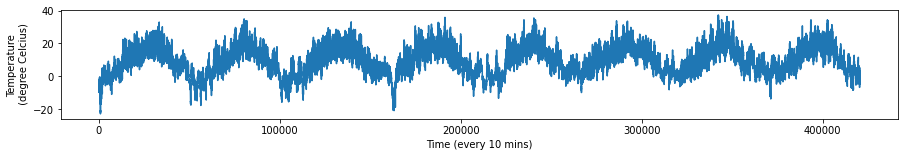

In [2]:
data = pd.read_csv('../data/jena_climate_2009_2016.csv')
data = data.iloc[:, 1:].astype(float).to_numpy()
temp = data[:, 1]  #temperature (in degrees Celsius)
plt.figure(figsize=(15,2))
plt.plot(range(len(temp)), temp)
plt.ylabel('Temperature\n (degree Celcius)')
plt.xlabel('Time (every 10 mins)')
plt.show()

Time series is anything that has been recorded sequentially over a period of time -- regular or irregular. In any case, the goal is to see if the observed patterns can help us ***forecast*** a period of time into the future.

## 2. Time Series Forecasting
Forecasting is predicting future values of our time series given all available information such as historical data and any possible variables that can influence the data. Besides Crypto Currencies, there are multiple important areas where time series forecasting is used for example : forecasting Sales, Call Volume in a Call Center, Solar activity, Ocean tides, Stock market behaviour, and many others. Assume the Manager of a hotel wants to predict how many visitors should he expect next year to accordingly adjust the hotel’s inventories and make a reasonable guess of the hotel’s revenue. Based on the data of the previous years/months/days, (S)he can use time series forecasting and get an approximate value of the visitors. Forecasted value of visitors will help the hotel to manage the resources and plan things accordingly.

There are a lot of things to consider before we forecast our time-series:
1. The kind of data (Trends, Seasonality, etc)
1. Factors that influence it (Multivariate Analysis, Causality, etc)
1. The amount of data available

Through out the following Chapters, we will discuss different forecasting methods how they are used. Each method have their own sets of assumptions and limitations, but the general idea is we assume that there is a fundamental mathematical process that defines our time-series. Understanding these mathematical processes helps us find the best method or algorithm (and the corresponding hyperparameters) to better forecast our time-series.

In the next section, we'll discuss the first formulation of time-series data sets, ***Stochastic Processes***. 

## 3. Stochastic Processes

A stochastic, or random process (process hereon) is a series of indexed random variables. In the context of time series analysis, we'll use $t = 0, 1, 2, ...$, (discrete) time, as an index.

$\lbrace \mathbf{X_0}, \mathbf{X_1}, \mathbf{X_2}, ...\rbrace$ denotes a process where $\mathbf{X_0}, \mathbf{X_1}, \mathbf{X_2}, ...$ are random variables.

A time series, in this context, is a series of indexed values, where each value is an _outcome_ of a random variable. In other words, a time series is one realization of a corresponding process.

__Example 1: Bernoulli trials.__ Recall that a Bernoulli trial has two possible outcomes or realizations. Let's take them to be $\{-1, +1\}$. Let's generate a few values:

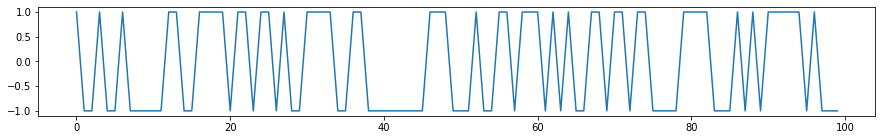

In [3]:
bern_outcomes = [-1., 1.]
size = 100
# Generate 100 Bernoulli trials
flips = rng.choice(bern_outcomes, size=size)
series = pd.Series(flips)
fig, ax = plt.subplots(figsize=(15, 2))
series.plot(ax=ax) # here we implicitly index them; let the index stand for time
plt.show()

__Example 2: Gaussian white noise.__ A Gaussian white noise process generates a time series in which each value was drawn from a Gaussian distribution with zero mean and unit variance: $\bf{X_t} \sim Gaussian(0, 1)$:

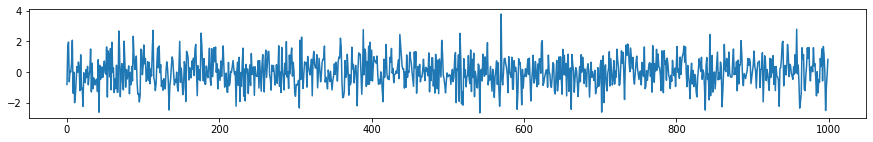

In [4]:
size = 1000
wn = st.norm.rvs(size=size)
wn_series = pd.Series(wn)
fig, ax = plt.subplots(figsize=(15, 2))
wn_series.plot(ax=ax)
plt.show()

Gaussian white noise has the properties of being _independent_ and _identically-distributed_, which leads some key properties for linear time series, to be brought up below.

__Example 3: Brownian motion in one dimension.__ One-dimensional Brownian motion, or Wiener process, can be thought of as the cumulative sum of white noise time series. The value of the series at $t$ is a sum of all preceding values, and can be thought of as a random walker's displacement at time $t$: $X_t = X_{t_1} + X_{t-2}  + ... = \sum_{i=0}^{t}{X_i}$.

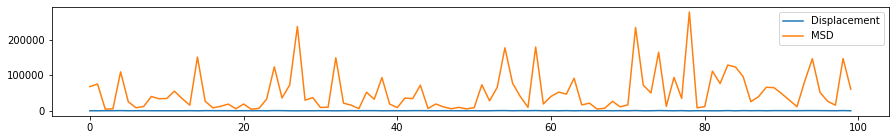

In [5]:
size = 100000
bms = []
bms_msq = []
for i in range(100):
    wn = st.norm.rvs(size=size)
    bm = np.cumsum(wn)
    bms.append(bm)
    bms_msq.append([x**2 for x in bm])
bm_ave = np.mean(bms, axis=1)
bm_msq = np.mean(bms_msq, axis=1)

fig, ax = plt.subplots(figsize=(15, 2))
bms_series = pd.Series(bm_ave)
bms_msq_series = pd.Series(bm_msq)
bms_series.plot(label="Displacement", ax=ax)
bms_msq_series.plot(label="MSD", ax=ax)
plt.legend()
plt.show()

__Example 4: Moving average.__ Given a white noise process (see above), a moving average process of order ($q$) can be generated by taking a weighted sum of the present and the previous $q$ values of the white noise at each time $t$: 

$X_t = \epsilon_t + a_1\epsilon_{t-1} + ... + a_q\epsilon_{t-q}$, 

where $\{\epsilon_t\} \sim WN(0, \sigma^2)$. We write $\{X_t\} \sim MA(q)$. The $MA$ process is an example of a _linear process._

Let's consider an $MA(2)$ process with $a_1 = 0.5$ and $a_2 = 0.25$. Then 

$X_t = \epsilon_t + 0.5\epsilon_{t-1} + 0.25\epsilon_{t-2}$.

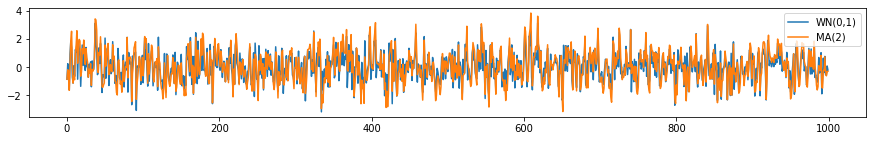

In [6]:
def ma2(wn):
    x = []
    # First element is just epsilon_t
    x.append(wn[0])
    # For the second element, let's take just the first coefficient (admittedly a judgment call)
    x.append(0.5*wn[0] + wn[1])
    # For the rest, use the full equation
    for t in range(2, len(wn)):
        x.append(wn[t] + 0.5*wn[t - 1] + 0.25*wn[t - 2])
    return np.array(x)

size = 1000
wn = st.norm.rvs(size=size)
ma2_series = pd.Series(
    ma2(wn)
)
wn_series = pd.Series(wn)
fig, ax = plt.subplots(figsize=(15, 2))
wn_series.plot(label="WN(0,1)", ax=ax)
ma2_series.plot(label=r"MA(2)", ax=ax)
plt.legend(loc="best")
plt.show()

__Exercise 1: Autoregressive process.__ Given a white noise process (see above), a time series from an autoregressive process of order $p$ can be generated by taking a weighted sum of the previous $p$ values of the time series, plus white noise at each time $t$: 

$X_t = b_{1}X_{t-1} + ... + b_{p}X_{t-p} + \epsilon_{t}$, 

where $\{\epsilon_t\} \sim WN(0, \sigma^2)$. We write $\{X_t\} \sim MA(q)$. 

Given an $AR(2)$ process with $b_1 = 0.6, b_2 = -0.2$, generate and plot a time series, similar to the $MA(1)$ example above. 

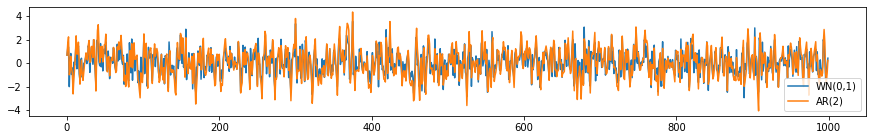

In [7]:
def ar2(wn):
    x = []
    # First element is just epsilon_t
    x.append(wn[0])
    # For the second element, let's take just the first coefficient (admittedly a judgment call)
    x.append(0.6*x[0] + wn[1])
    # For the rest, use the full equation
    for t in range(2, len(wn)):
        x.append(wn[t] + 0.6*x[t - 1] + -0.2*x[t - 2])
    return np.array(x)
        
size = 1000
wn = st.norm.rvs(size=size)
ar2_series = pd.Series(
    ar2(wn)
)
wn_series = pd.Series(wn)
fig, ax = plt.subplots(figsize=(15, 2))
wn_series.plot(label="WN(0,1)", ax=ax)
ar2_series.plot(label=r"AR(2)",ax=ax)
plt.legend(loc="best")
plt.show()

### Stationarity

Consider a process $\{X_t\}$, with corresponding joint distribution $P(X_{t_1 + \tau}, X_{t_2 + \tau}, ..., X_{t_n + \tau})$ at times $t_1 + \tau, t_2 + \tau, ..., t_n + \tau$.

This process is _stationary_ if: 

$P(X_{t_1 + \tau}, X_{t_2 + \tau}, ..., X_{t_n + \tau}) = P(X_{t_1}, X_{t_2}, ..., X_{t_n})$ for $\tau, t_1 ... t_n$ and $n$.  

Essentially, the statistics of a stationary process is invariant to time-translation. 

$\{X_t\}$ is _weakly stationary_ if: 

(i) $\mu(X_t) = \mu(X_{t + \tau}) = \mu$ for all $\tau$,\
(ii) $\Gamma(t_1, t_2) = \Gamma(t_1 - t_2)$, and \
(iii) $E[|X_t|^2] < \infty$.

In the above, $\Gamma(t_1, t_2)$ is the _autocovariance_, defined by: 

$\Gamma(t_1, t_2) = cov~(t_1, t_2) = E\left[(X_{t_1} - \mu(X_{t_1}))(X_{t_2} - \mu(X_{t_2}))\right]$

Weak stationarity implies that the lag, $\tau$, can be used to parametrize the autocovariance, leading to: 

$\Gamma(\tau)  = E\left[(X_t - \mu)(X_{t + \tau} - \mu)\right]$.

Normalizing the autocovariance by the standard deviations at $t_1$ and $t_2$ yields the _autocorrelation_: 

$P(t_1, t_2) = \frac{cov~(t_1, t_2)}{\sigma_{t_1}\sigma_{t_2}} = \frac{E\left[(X_{t_1} - \mu(X_{t_1}))(X_{t_2} - \mu(X_{t_2}))\right]}{\sigma_{t_1}\sigma_{t_2}}$

And for a weak stationary process:

$P(\tau) = \frac{E\left[(X_t - \mu)(X_{t + \tau} - \mu)\right]}{\sigma^2}$

For Gaussian white noise, weak stationarity implies stationarity, something not always valid for other processes.

### Autocovariance of a stationary process

The autocovariance matrix of a stationary process has a particular form. Letting $\tau = |t_1 - t_2|$ be the _lag_, for $n$ successive observations from the time series ${X_t}$, the autocovariance matrix is symmetric and positive-definite, given by: 

$
    \Gamma_n = \begin{pmatrix}
                    \gamma_0 & \gamma_1 & \gamma_2 & \cdots & \gamma_{n-1} \\
                    \gamma_1 & \gamma_0 & \gamma_1 & \cdots & \gamma_{n-2} \\
                    \gamma_2 & \gamma_1 & \gamma_0 & \cdots & \gamma_{n-3} \\
                    \vdots   & \vdots   &  \vdots  & \ddots &  \vdots \\
                    \gamma_{n-1} & \gamma_{n-2} & \cdots & \gamma_{n-3} & \gamma_0
                \end{pmatrix}
$

Since for a stationary process the variance at zero lag is constant, the _autocorrelation matrix_ is given by:

$
    P_n = \sigma^2\Gamma_n = \begin{pmatrix}
                    1 & \rho_1 & \rho_2 & \cdots & \rho_{n-1} \\
                    \rho_1 & 1 & \rho_1 & \cdots & \rho_{n-2} \\
                    \rho_2 & \rho_1 & 1 & \cdots & \rho_{n-3} \\
                    \vdots   & \vdots   &  \vdots  & \ddots &  \vdots \\
                    \rho_{n-1} & \rho_{n-2} & \cdots & \rho_{n-3} & 1
                \end{pmatrix}
$

The _autocovariance function_, $\Gamma(\tau)$, can simply be read off from the diagonals of the autocovariance matrix; likewise with the _autocorrelation function_.

__Q.__ What is the autocorrelation function for the Gaussian white noise process with zero mean and unit variance?

__A.__ Since the values are iid, the values are uncorrelated, thus: 

$P(\tau) = \delta_{\tau,0}$

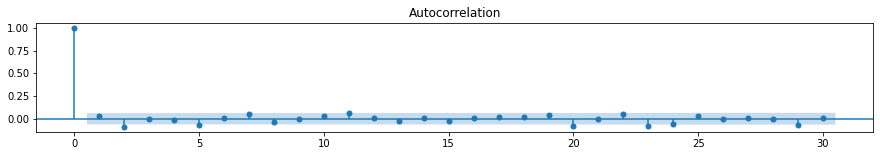

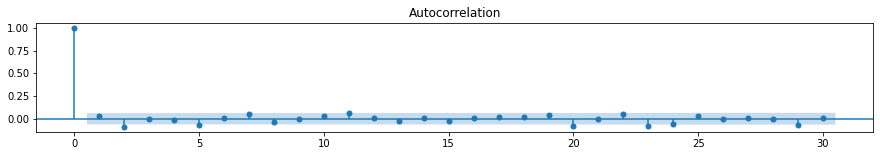

In [8]:
#Plotting:
tg.plot_acf(wn_series)

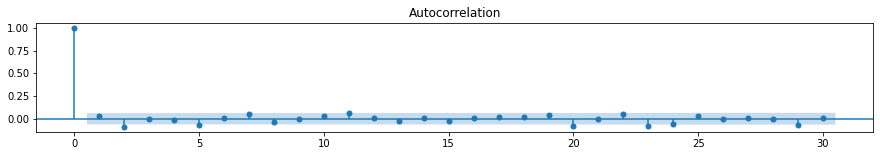

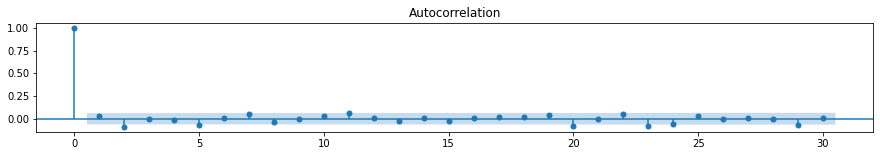

In [9]:
#Plotting:
tg.plot_acf(wn)

Autocorrelations for other time series above:

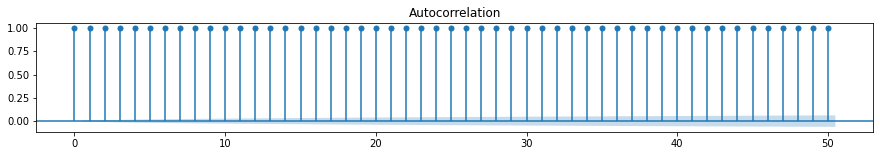

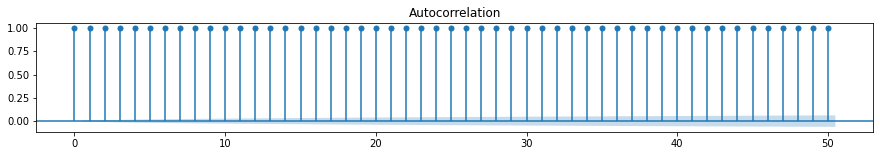

In [10]:
tg.plot_acf(bm)

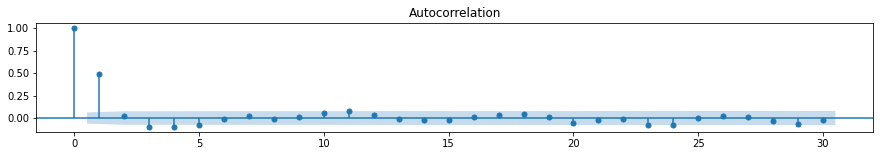

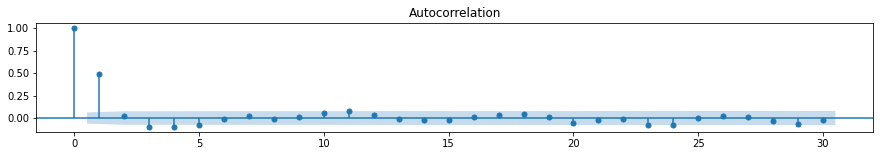

In [11]:
tg.plot_acf(ar2_series)

What is the autocorrelation of the $AR(2)$ process above?

### Moving Average Process

From above, ${X_t}$ is a _moving average_ process of order $q$ if $X_t$ follows: 

$X_t = \epsilon_t + a_1\epsilon_{t-1} + ... + a_q\epsilon_{t-q}$.

Let's use the backward shift, or lag operator $\bf{B}$:

$\mathbf{B} X_t = X_{t-1}$ \
$\mathbf{B}^2 X_t = X_{t-2}$

and so on. We can rewrite the above as:

$X_t = \epsilon_t + a_1\mathbf{B}\epsilon_t + ... + a_q\mathbf{B}^q\epsilon_{t}$

$X_t = \theta(\mathbf{B})\epsilon_t$, where  

$\theta(\mathbf{B}) =  1 + a_1\mathbf{B} + ... + a_q\mathbf{B}^q$, with an associated polynomial

$\theta(z) =  1 + a_1z + ... + a_qz^q = \sum_{j=0}^q{a_jz^j}$.

### Autoregressive Process

From above, ${X_t}$ is an _autoregressive_ process of order $p$ if $X_t$ follows:  

$X_t = b_{1}X_{t-1} + ... + b_{p}X_{t-p} + \epsilon_{t}$.

Rewriting and using $\mathbf{B}$:

$X_t - b_{1}X_{t-1}~ - ...~ - b_{p}X_{t-p} = \epsilon_{t}$ 

$(1 - b_1\mathbf{B}~ - ...~ - b_p\mathbf{B}^p)X_t = \epsilon_{t}$

$\phi(\mathbf{B})X_t = \epsilon_{t}$, where

$\phi(\mathbf{B}) = 1 - b_1\mathbf{B}~ - ... - b_p\mathbf{B}^p$, and associated polynomial

$\phi(z) = 1 - b_1z~ - ... - b_pz^p = \sum_{j=0}^{p}{b_jz^j}$.

### Autoregressive Moving Average Process

Combining the two yields the _autoregressive moving average_ process of order $(p, q)$:

$X_t = \epsilon_t + a_1\epsilon_{t-1} + ... + a_q\epsilon_{t-q} + b_{1}X_{t-1} + ... + b_{p}X_{t-p}$

This can be rewritten as:

$\phi(\mathbf{B})X_t = \theta(\mathbf{B})\epsilon_t$,

with the characteristic polynomials as defined above.

## 4. Benchmark Methods

In order to properly measure the performance of a forecasting model, we first need to establish several baselines. This section introduces several methods that will serve as benchmarks. Obviously, any forecasting method we develop must beat these benchmarks. Otherwise, the new method is not even worth considering.

In the notation below, $T$ refers to the length of the time series and $h$ refers to the prediction horizon.

### Naïve Method

Forecasts of all future values are equal to the last observation.

\begin{align*}
    \hat{y}_{T+h} &= y_T
\end{align*}

### Seasonal Naïve Method

Forecasts are equal to the last observed value from the same season of the year (e.g. the same month of the previous year). 

\begin{align*}
    \hat{y}_{T+h} &= y_{T+h-m(k+1)}
\end{align*}

where $m$ is the seasonal period and $k$ is the integer part of $(h-1)/m$ (i.e. the number of complete years in the forecast period prior to time $T+h$).

As an example, if we were forecasting a monthly time series, the forecast for all future February values is simply equal to the last observed February value. With weekly data, the forecast of all future Friday values is equal to the last observed Friday value. And so on.

## 5. Evaluation Metrics for Forecast Accuracy

Forecasting is one of the most common inference tasks in time series analysis. In order to properly gauge the performance of a time series model, it is common practice to divide the dataset into two parts: training and test data. Model parameters are estimated using training data, then the models are used to generate forecasts that are evaluated against the test data.

Error statistics come in different flavors, each with their own advantages and disadvantages.

### Mean Absolute Error

The most commonly used metric is the <b><i>mean absolute error</i></b> or <b>MAE</b>. Its main advantage is that is easy to understand and compute. We note that the metric is scale-dependent, meaning that it cannot be compared to other time series that have different units. In addition, methods that minimize MAE generate forecasts that lead to the median.

\begin{align*}
    \text{MAE} &= \frac{1}{n}\sum_{t=1}^{n} |y_t - \hat{y}_t|
\end{align*}

### Root Mean Squared Error

Another commonly used metric is the <b><i>root mean squared error</i></b> or <b>RMSE</b>, although it is more difficult to interpret. Methods that minimize RMSE generate forecasts that lead to the mean and, similar to MAE, RMSE is scale-dependent.

\begin{align*}
    \text{RMSE} &= \sqrt{\frac{1}{n}\sum_{t=1}^{n} (y_t - \hat{y}_t)^2}
\end{align*}

### Mean Absolute Percentage Error

In order to make comparisons between time series that have different units, one can use percentage errors. One frequently used percentage-based metric is the <b><i>mean absolute percentage error</i></b> or <b>MAPE</b>. Unfortunately, the main disadvantage of percentage errors is that they may be infinite or undefined when $y_t$ is zero or close to zero.

\begin{align*}
    \text{MAPE} &= \frac{1}{n}\sum_{t=1}^{n} \bigg|\frac{y_t - \hat{y}_t}{y_t}\bigg|
\end{align*}

### Symmetric Mean Absolute Percentage Error

One particular disadvantage of MAPE is that it puts a larger penalty on negative errors compared to positive errors. This leads to an alternative percentage-based metric called <b><i>symmetric mean absolute percentage error</i></b> or <b>SMAPE</b>. However, calculating the metric can still be unstable if $y_t$ and $\hat{y}_t$ are both close to zero.

\begin{align*}
    \text{SMAPE} &= \frac{1}{n}\sum_{t=1}^{n} \frac{|\hat{y}_t - y_t|}{|y_t| + |\hat{y}_t|}
\end{align*}

## 6. Summary of Forecast Accuracy for Jena Climate Dataset

The handbook goes over several time series forecasting methods and compares performance of said models on the Jena Climate Dataset. Specifically, each method attempts to forecast the temperature variable (in Celsius). A summary of the forecast accuracy for each model is shown below.

<table>
  <thead>
    <tr>
      <th>Method</th>
      <th>Average MAE (Celsius)</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Naive</td>
      <td>3.18</td>
    </tr>
    <tr>
      <td>Seasonal Naive</td>
      <td>2.61</td>
    </tr>
      <tr>
      <td>Linear Regression</td>
      <td>2.86</td>
    </tr>
      <tr>
      <td>ARIMA</td>
      <td>3.19</td>
    </tr>
      <tr>
      <td>VAR</td>
      <td>2.54</td>
    </tr>
      <tr>
      <td>Simplex Method (pending validation)</td>
      <td>1.53</td>
    </tr>
    <tr>
      <td>LightGBM</td>
      <td>2.08</td>
    </tr>
  </tbody>
</table>